In [85]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.cluster import SpectralClustering
import psutil
import os
import random
import torch
from datetime import datetime, timedelta

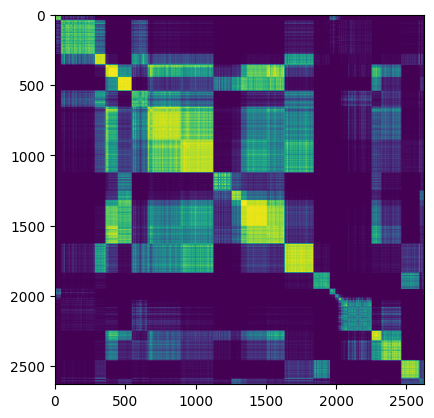

In [48]:
plt.imshow(adj)

In [12]:
print(f"Memory usage: {bytes_to_mb(get_memory_usage())} MB")
G = nx.Graph()

# Add nodes with 50 features each
for i in range(10000):
    features = {f"feature_{j}": random.random() for j in range(50)}
    G.add_node(i, **features)

# Add 7 million edges
edges = set()
while len(edges) < 7000000:
    u = random.randint(0, 9999)
    v = random.randint(0, 9999)
    if u != v:
        edges.add((u, v))

G.add_edges_from(edges)
print(f"Full Mem Memory usage: {bytes_to_mb(get_memory_usage())} MB")
del edges
del features
print(f"Del edges/features Memory usage: {bytes_to_mb(get_memory_usage())} MB")
del G
print(f"Del G Memory usage: {bytes_to_mb(get_memory_usage())} MB")


Memory usage: 1195.12890625 MB
Full Mem Memory usage: 2331.76171875 MB
Del edges/features Memory usage: 2075.78515625 MB
Del G Memory usage: 1181.23046875 MB


In [68]:
  

def generate_parametric_product_graph(s00, s01, s10, s11, A_T, A_N, spatial_graph):
    print("Generating product graph...")
    I_T = np.identity(len(A_T))
    I_N = np.identity(len(A_N))
    S_diamond = (
        s00 * np.kron(I_T, I_N) +
        s01 * np.kron(I_T, A_N) +
        s10 * np.kron(A_T, I_N) +
        s11 * np.kron(A_T, A_N)
    )
    product_graph = nx.from_numpy_array(S_diamond)
    
    # Add features to the product graph
    num_nodes = A_N.shape[0]
    num_timesteps = A_T.shape[0]
    
    for t in range(num_timesteps):
        for node in range(num_nodes):
            original_node = node #node_list[node]  # Adjust if necessary
            new_node = t * num_nodes + node
            product_graph.nodes[new_node]['feature'] = spatial_graph.nodes[original_node]['feature']
    
    print("Product graph generated")
    return product_graph


def perform_spectral_clustering(n_clusters, adj):
    print("Clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = spectral.fit_predict(adj)
    
    # Generate adjacency matrices for subgraphs based on clustering labels
    subgraph_adj_matrices = []
    original_node_ids = []
    
    for cluster in range(n_clusters):
        nodes_in_cluster = [i for i in range(len(labels)) if labels[i] == cluster]
        subgraph_adj_matrix = adj[np.ix_(nodes_in_cluster, nodes_in_cluster)]
        subgraph_adj_matrices.append(subgraph_adj_matrix)
        if cluster < len(listings):
            node_ids = listings.iloc[nodes_in_cluster]['id'].tolist()
            original_node_ids.append(node_ids)
    
    print("Clustering completed")
    return subgraph_adj_matrices, original_node_ids



def sample_nodes(adj_matrix, M, k):
    """
    Perform spatial clustering by sampling M nodes and including their top-k neighbors based on edge weights.
    
    Parameters:
    adj_matrix (torch.Tensor): The adjacency matrix of the entire graph (shape: [num_nodes, num_nodes]).
    M (int): The number of nodes to sample.
    k (int): The number of top neighbors to sample based on edge weights.
    
    Returns:
    list: List of node indices of the sampled nodes and their neighbors.
    torch.Tensor: The adjacency matrix of the subgraph.
    """
    num_nodes = adj_matrix.shape[0]
    
    # Sample M unique nodes
    sampled_nodes = np.random.choice(num_nodes, M, replace=False)
    
    # Create a mask for sampled nodes and their top-k neighbors
    node_mask = torch.zeros(num_nodes, dtype=torch.bool)
    node_mask[sampled_nodes] = True
    if isinstance(adj_matrix, np.ndarray):
        adj_matrix = torch.tensor(adj_matrix, dtype=torch.float)
    for node in sampled_nodes:
        # Get the neighbors and their edge weights
        neighbors = torch.nonzero(adj_matrix[node] > 0).view(-1)
        neighbor_weights = adj_matrix[node, neighbors]
        
        # Sort neighbors by edge weight and take the top k
        if neighbors.size(0) > k:
            top_k_neighbors = neighbors[torch.topk(neighbor_weights, k).indices]
        else:
            top_k_neighbors = neighbors
        
        node_mask[top_k_neighbors] = True
    
    # Get the final list of nodes (sampled nodes + their top-k neighbors)
    final_nodes = torch.nonzero(node_mask).view(-1)
    
    # Create the subgraph adjacency matrix
    subgraph_adj_matrix = adj_matrix[final_nodes][:, final_nodes]
    
    return final_nodes.tolist(), subgraph_adj_matrix

def adjacency_to_edge_list(adj):
    edge_list = []
    num_nodes = adj.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj[i][j] != 0:
                edge_list.append((i,j))
    edge_list = np.array(edge_list)
    return edge_list
    
def create_sequences(listing_ids,obs_window,pred_horizon):
    # nodes is the index of the nodes in the graph
    calendar = pd.read_csv(folder+'preprocessed/calendar.csv')
    calendar['date'] = pd.to_datetime(calendar['date'])
    filtered_calendar = calendar[calendar['listing_id'].isin(listing_ids)]
    price_matrix = filtered_calendar.pivot(index='listing_id', columns='date', values='price')
    X, y = [], []
    for listing_id in price_matrix.index:
        data = price_matrix.loc[listing_id].values
        for i in range(len(data) - T - h + 1):
            X.append(data[i:i+T])
            y.append(data[i+T+h-1])
    return np.array(X), np.array(y)

def add_features_to_graph(node_list, graph, features):
    for i, node in enumerate(node_list):
        graph.nodes[i]['feature'] = {feature: features[feature][node] for feature in features}

In [100]:
folder = "/home/dlayh/Coding/Graph_Project/ML4G-Project-main/data/"
file = "adjacency/sigma15"
#file = "sigma25"
#file = "sigma2"
adj = np.load(folder+file+'.npy')
calendar = pd.read_csv(folder+'preprocessed/calendar.csv')
listings = pd.read_csv(folder+'preprocessed/listings.csv')


pred_horizon = 1
obs_window = 3

# Assuming 4 timesteps and predicting a fifth timestep
A_T = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0]
])
# Assuming 3 timesteps and predicting a fourth timestep
A_T = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]
])
binary_adj = [1 for y in adj for x in y if x!=0]
print(sum(binary_adj)/adj.shape[0]**2)

#subgraphs_adj,original_node_indices = perform_spectral_clustering(10,adj)
node_list, sampled_adj = sample_nodes(adj, 100, 2)
spatial_graph = nx.from_numpy_array(sampled_adj.numpy())

features = ['minimum_nights','square_feet','bathrooms', 'bedrooms', 'beds', 'bed_type']
node_features = listings[features]

add_features_to_graph(node_list, spatial_graph, node_features)

product_graph = generate_parametric_product_graph(0, 1, 1, 0, A_T, sampled_adj, spatial_graph)

def add_labels(G,node_list,time_steps,starting_date):
    num_nodes = len(G.nodes)    
    for t in range(time_steps):
        date_obj = datetime.strptime(starting_date, '%Y-%m-%d')
        new_date_obj = date_obj + timedelta(days=t)
        new_date_str = new_date_obj.strftime('%Y-%m-%d')
        labels = calendar[calendar["date"] == new_date_str]
        for node in range(num_nodes):
            print(node,node_list[node])
            print(labels)
            label = labels[node_list[node]].price
            original_node = node #node_list[node]  # Adjust if necessary
            new_node = t * num_nodes + node
            G.nodes[new_node]['label'] = label 

labeled_product_graph = add_labels(product_graph,node_list,obs_window+pred_horizon,starting_date = '2016-12-01')
#for i, (subgraph_adj, original_indices) in enumerate(zip(subgraphs_adj[:1], original_node_indices[:1])):
#    if max(original_indices) < len(node_features):
#        subgraph_features = node_features.iloc[original_indices]
#    else:
#        subgraph_features = 0
#    # Generate parametric product graph for the subgraph
#    G_nx = generate_parametric_product_graph(0, 1, 1, 0, A_T, subgraph_adj)
        
    # Add features to nodes
#    for idx, node in enumerate(G_nx.nodes()):
#        if idx < len(subgraph_features):
#            for feature in features:
#                G_nx.nodes[node][feature] = subgraph_features.iloc[idx][feature]
            #G_nx.nodes[node]['label'] = subgraph_labels.iloc[idx]['label']


0.5493084782615301
Generating product graph...
Product graph generated
0 1
        Unnamed: 0  listing_id        date available  price
0                0        5506  2016-12-01         t  145.0
279            279        6695  2016-12-01         t  195.0
558            558        6976  2016-12-01         f   65.0
837            837        9273  2016-12-01         t  225.0
1116          1116        9765  2016-12-01         t  209.0
...            ...         ...         ...       ...    ...
732375      732375    14924831  2016-12-01         t  162.0
732654      732654    14928000  2016-12-01         t   55.0
732933      732933    14928333  2016-12-01         t   90.0
733212      733212    14933380  2016-12-01         t   49.0
733491      733491    14933461  2016-12-01         f  165.0

[2630 rows x 5 columns]


KeyError: 1

In [71]:
def tikhonov(lambda_reg,y,matrix):
    A = np.matmul(matrix.T,matrix) + lambda_reg*np.identity(32)
    B = np.matmul(np.matmul(matrix.T,matrix),y)
    return np.matmul(np.linalg.inv(A),B)

In [96]:
starting_date = '2016-12-01'
date_obj = datetime.strptime(starting_date, '%Y-%m-%d')
t = 1
new_date_obj = date_obj + timedelta(days=t)
new_date_str = new_date_obj.strftime('%Y-%m-%d')
print(new_date_str)
temp = calendar[calendar["date"] == new_date_str]
temp.head()
temp.loc[280].price

2016-12-02


195.0

In [8]:
with open('edge_list.txt', 'w') as f:
    for edge in edge_list:
        f.write(f"{edge[0]} {edge[1]}\n")

In [4]:
loaded_edge_list = []
with open('edge_list.txt', 'r') as f:
    for line in f:
        node1, node2 = map(int, line.split())
        loaded_edge_list.append((node1, node2))
G = nx.Graph()
G.add_edges_from(loaded_edge_list)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

print(f"Graph with {num_nodes} nodes and {num_edges} edges")
print(f"Directed: {is_directed}")

Graph with 10516 nodes and 7606391 edges
Directed: False


AttributeError: module 'networkx' has no attribute 'info'

In [5]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_loaded)
nx.draw(G_loaded, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Loaded Graph from Edge List")
plt.show()

KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>